In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1. Load data

In [2]:
def numerify(var):
    """
    Cast an object as an int or float if possible. Otherwise return unmodified
    """
    
    if isinstance(var, str):
        try:
            var = int(var)

        except:
            try:
                var = float(var)
            except:
                pass
    else:
        pass
            
    return var

In [3]:
#write a nice data loader
#should return metadata as a dict, data in a pandas df


def read_1D_data(fp):
    """
    Read a 1D Xenocs data .dat file
    """
    metadata = {}
    q = []
    I = []
    sig = []
    header_count = 0

    in_data = False # flag for if we are read into data yet

    with open(fp, 'rt') as f:
        for line in f:
            if not in_data:
                if line[:2] == '##': #metadata section header 
                    header_count +=1
                    continue
                elif line[:2] == '# ':
                    items = line.split()
                    metadata[items[1]] = numerify(items[2])

                elif line[0] == 'q' and header_count == 2:
                    in_data = True
            elif in_data:
                vals = line.split()
                q.append(numerify(vals[0]))
                I.append(numerify(vals[1]))
                sig.append(numerify(vals[2]))


    data = pd.DataFrame({'q':q, 'I':I, 'sig':sig})
    
    return data, metadata
                

        

In [32]:
esaxs_data, esaxs_metadata = read_1D_data('data/Data_0_00002.dat')
saxs_data, saxs_metadata = read_1D_data('data/Data_0_00016.dat')
maxs_data, maxs_metadata = read_1D_data('data/Data_0_00030.dat')

esaxs_bkg_data, esaxs_bkg_metadata = read_1D_data('data/Data_0_00012.dat')
saxs_bkg_data, saxs_bkg_metadata = read_1D_data('data/Data_0_00026.dat')
maxs_bkg_data, maxs_bkg_metadata = read_1D_data('data/Data_0_00040.dat')

## 2. Subtract background

In [33]:
data1 = esaxs_data
data2 = esaxs_bkg_data

#scale data2 onto data1

scale_qmin = 1e-4
scale_qmax = 1e-3

def scale_data(data1, data2, scale_qmin, scale_qmax):
    """
    scale data2 onto data1 using a scale factor calculated from the difference in integrals of data1 and data2 over the range scale_qmin -> scale_qmax
    """

    # get yvals for each dataset
    inrange_data1 = data1[data1['q'].between(scale_qmin, scale_qmax, inclusive = 'both')]
    inrange_data2 = data2[data2['q'].between(scale_qmin, scale_qmax, inclusive = 'both')]

    assert np.isclose(inrange_data1['q'].iloc[0], inrange_data2['q'].iloc[0])
    assert np.isclose(inrange_data1['q'].iloc[-1], inrange_data2['q'].iloc[-1])


    x1 = inrange_data1['q'].to_numpy()
    x2 = inrange_data2['q'].to_numpy()
    y1 = inrange_data1['I'].to_numpy()
    y2 = inrange_data2['I'].to_numpy()
    #check for nans in y values

    #trapezoid rule integrate
    scale1 = np.trapz(y1, x1)/(x1[-1] - x1[0])
    scale2 = np.trapz(y2, x2)/(x2[-1] - x2[0])

    scale_factor = scale1/scale2


    # scale data2 with scale factor
    data2_out = data2.copy()

    data2_out['I'] = data2['I']*scale_factor

    return data2_out


In [36]:
#run subtraction with scaled data

data2_scaled = scale_data(data1, data2, scale_qmin, scale_qmax)

# check that q values line up for everything
assert np.isclose(data1['q'].to_numpy(), data2_scaled['q'].to_numpy()).all()
# once we get fancier look into allowance for slop or interpolation options. For now throw out anything not compliant ^^

subtracted_data = data1.copy()

subtracted_I = data1['I'] - data2_scaled['I']
#get rid of negative values
#subtracted_I = np.delete(subtracted_I, subtracted_I < 0)
#np.delete(

subtracted_data['I'] = subtracted_I

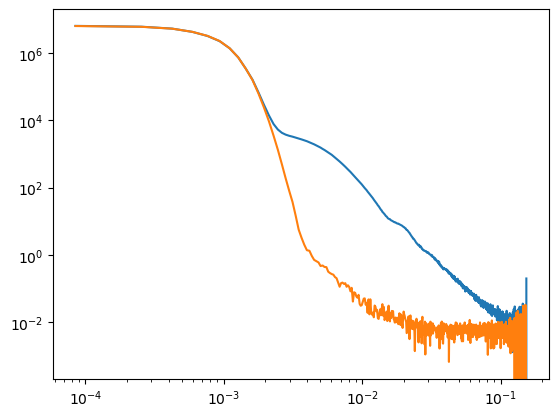

In [37]:
plt.loglog(data1['q'], data1['I'])
plt.loglog(data2_scaled['q'], data2_scaled['I'])

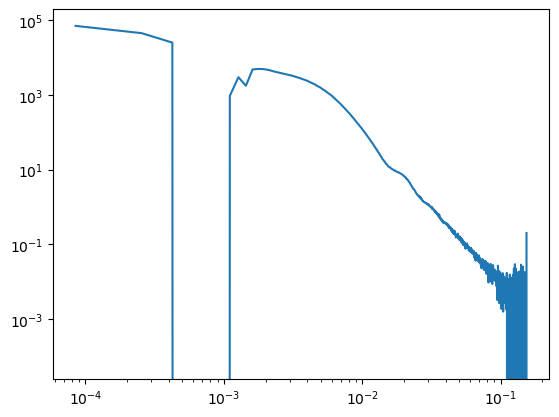

In [38]:
plt.loglog(subtracted_data['q'], subtracted_data['I'])

## 3. Data merge

In [ ]:
#1. Figure out 'good' range for each data

#low end: this is hard. probably use hard-coded qmin for now

#upper end: do some sort of noise quantification. Maybe max-min over last 3 data points < 5% of average value? 

# 2. determine overlapping range for the 2 data sets

#3. Looking within overlapping range, apply rules to figure something out

    # - slopes should match
    # - values should be close 
    
    

In [42]:
l = [1,2,3]

In [45]:
l.pop(0)

1

In [46]:
l

[2]

In [65]:
last_3_Is

[0.0, 0.1998208856884082]

In [82]:
#iterate over values in I
last_3_Is = []
variance = []
avg = []
ranges = []


for i, row in data1.iterrows():
    I = row['I']
    if i < 5:
        last_3_Is.append(I)
        continue
    else:
        
        if i == 100:
            print(len(last_3_Is))
        
        last_3_Is.append(I)
        
        Imin = min(last_3_Is)
        Imax = max(last_3_Is)
        Iavg = np.log(np.mean(last_3_Is))
        
        Irange = np.log(Imax) - np.log(Imin)
        avg.append(Iavg)
        ranges.append(Iavg)
        
        var = Irange/Iavg
        
        variance.append(var)
        last_3_Is.pop(0)
        
        
        

# For last 3 values, get min and max val

# min-max should be less than x % of average of last 3 values 


5


/tmp/ipykernel_5466/1559568081.py:24: RuntimeWarning: divide by zero encountered in log
  Irange = np.log(Imax) - np.log(Imin)
/tmp/ipykernel_5466/1559568081.py:22: RuntimeWarning: divide by zero encountered in log
  Iavg = np.log(np.mean(last_3_Is))
/tmp/ipykernel_5466/1559568081.py:24: RuntimeWarning: invalid value encountered in scalar subtract
  Irange = np.log(Imax) - np.log(Imin)


In [83]:
Irange

inf

In [84]:
Iavg

-3.4020933544839136

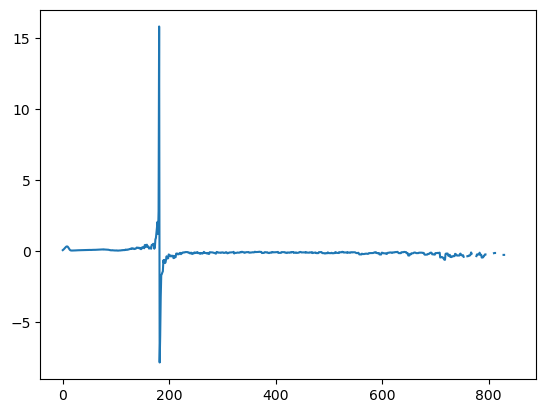

In [85]:
plt.plot(variance)

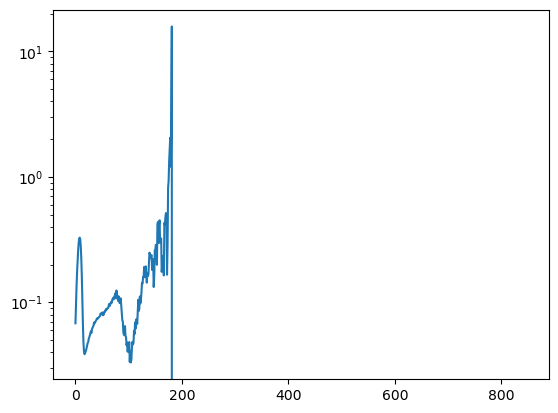

In [86]:
plt.semilogy(variance)

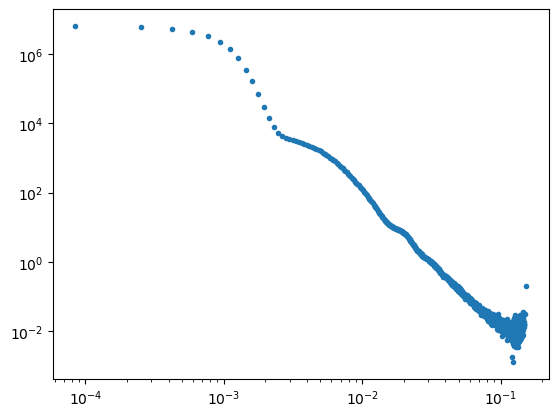

In [81]:
plt.loglog(data1['q'], data1['I'], ls = ' ', marker = '.')